# Cats and dogs

Come prima cosa estraiamo una parte di dati per lavorare in modo più leggero

In [28]:
from tensorflow import keras
import glob
import os
import random
import shutil
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## GPU setup
To Check if keras(>=2.1.1) is using GPU:

In [3]:
import tensorflow as tf
print("Elenco device disponibili")
tf.config.list_physical_devices('')
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPU available", len(gpus))
tf.config.experimental.set_memory_growth(gpus[0], True)

Elenco device disponibili
Num GPU available 1


In [4]:
def create_slim_data():
    if os.path.isdir('slim/train/dog') is False:
        print('Cartella con campione ridotto non trovata, procedo a crearla...')
        os.makedirs('slim/train/dog')
        os.makedirs('slim/train/cat')
        os.makedirs('slim/valid/dog')
        os.makedirs('slim/valid/cat')
        os.makedirs('slim/test/dog')
        os.makedirs('slim/test/cat')

        for f in random.sample(glob.glob('full/train/dog*'), 500):
            shutil.copy(f, 'slim/train/dog')
        for f in random.sample(glob.glob('full/train/cat*'), 500):
            shutil.copy(f, 'slim/train/cat')
        for f in random.sample(glob.glob('full/train/dog*'), 100):
            shutil.copy(f, 'slim/valid/dog')
        for f in random.sample(glob.glob('full/train/cat*'), 100):
            shutil.copy(f, 'slim/valid/cat')
        for f in random.sample(glob.glob('full/train/dog*'), 50):
            shutil.copy(f, 'slim/test/dog')
        for f in random.sample(glob.glob('full/train/cat*'), 50):
            shutil.copy(f, 'slim/test/cat')
    else:
        print('Cartella slim trovata, salto la creazione')

script_folder = globals()['_dh'][0]
print('Siamo nella cartella:', script_folder)
os.chdir(script_folder)
os.chdir('data')
create_slim_data()
os.chdir(script_folder)

Siamo nella cartella: C:\Workspace\keras-deeplizard\cats-dogs
Cartella slim trovata, salto la creazione


## Creazione dei batch


In [5]:

train_path = 'data/slim/train/'
valid_path = 'data/slim/valid/'
test_path = 'data/slim/test/'

vgg16_preprocessing_function = tf.keras.applications.vgg16.preprocess_input
target_size = (224,224)
classes = ['cat', 'dog']
batch_size = 10

train_batches = ImageDataGenerator(preprocessing_function=vgg16_preprocessing_function).flow_from_directory(
    directory=train_path,
    target_size=target_size,
    classes=classes,
    batch_size=batch_size
)
valid_batches = ImageDataGenerator(preprocessing_function=vgg16_preprocessing_function).flow_from_directory(
    directory=valid_path,
    target_size=target_size,
    classes=classes,
    batch_size=batch_size
)
# Non vogliamo che il test_batch sia mescolato perchè vogliamo potervi accedere quando facciamo la
# rappresentazione grafica tramite confusion matrix
test_batches = ImageDataGenerator(preprocessing_function=vgg16_preprocessing_function).flow_from_directory(
    directory=test_path,
    target_size=target_size,
    classes=classes,
    batch_size=batch_size,
    shuffle=False
)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [7]:
import matplotlib.pyplot as plt

def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
imgs, labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

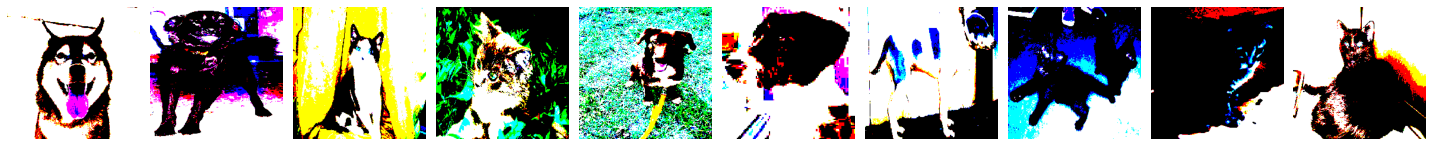

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [9]:
plot_images(imgs)
print(labels)

## Creazione e allenamento della CNN
Creiamo una convolutional neural network 2d dove scegliamo il numero di filtri in modo abbastanza arbitrario. La dimensione del kernel `(3,3)` invece è abbastanza standard. Input shape invece viene definito da `target_size=(224,224)` definito in precedenza e `3` i canali di colore RGB.

In [10]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2,2), strides=2),
     Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In questo caso usiamo `categorical_crossentropy` ma potremmo usare `binary_crossentropy` dato che il nostro output è binario e non abbiamo altre *tipologie* di animale. Nel caso in cui lo usassimo, avremmo come output un unico array. Il vantaggio (irrisorio) di usare `categorical_crossentropy` è non cambiare quasi nulla nel caso in cui si volesse aggiungere una categoria.

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
100/100 - 10s - loss: 10.1231 - accuracy: 0.6090 - val_loss: 5.9578 - val_accuracy: 0.5850
Epoch 2/10
100/100 - 4s - loss: 2.7341 - accuracy: 0.7240 - val_loss: 2.9540 - val_accuracy: 0.6500
Epoch 3/10
100/100 - 4s - loss: 0.5140 - accuracy: 0.8910 - val_loss: 3.3346 - val_accuracy: 0.6900
Epoch 4/10
100/100 - 4s - loss: 0.2789 - accuracy: 0.9330 - val_loss: 2.4531 - val_accuracy: 0.6850
Epoch 5/10
100/100 - 4s - loss: 0.1110 - accuracy: 0.9700 - val_loss: 3.3517 - val_accuracy: 0.6300
Epoch 6/10
100/100 - 4s - loss: 0.0985 - accuracy: 0.9680 - val_loss: 2.4123 - val_accuracy: 0.7000
Epoch 7/10
100/100 - 5s - loss: 0.0169 - accuracy: 0.9900 - val_loss: 2.4226 - val_accuracy: 0.6900
Epoch 8/10
100/100 - 5s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.3462 - val_accuracy: 0.6850
Epoch 9/10
100/100 - 5s - loss: 4.9458e-04 - accuracy: 1.0000 - val_loss: 2.3018 - val_accuracy: 0.7050
Epoch 10/10
100/100 - 5s - loss: 3.1636e-04 - accuracy: 1.0000 - val_loss: 2.3090 - val_accura

In questo caso è presente un problema di overfitting in quanto l'accuracy è bassa.

## Predict

Ricordiamoci che il test set non è mescolato

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

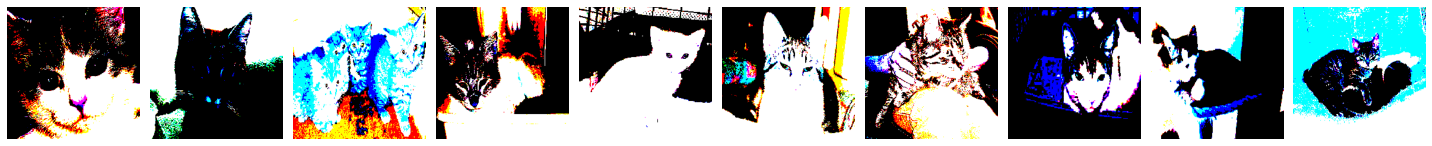

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [15]:
test_imgs, test_labels = next(test_batches)
plot_images(test_imgs)
print(test_labels)

In [17]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [19]:
predictions = model.predict(x=test_batches, verbose=0)

In [26]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.

In [64]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Questa funzione stampa una confusion matrix, la normalizzazione può essere applicata tramite il parametro `normalize=True`.
    :param cm:
    :param classes:
    :param normalize:
    :param title:
    :param cmap:
    :return:
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix without normalization")

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [65]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix without normalization
[[32 18]
 [21 29]]


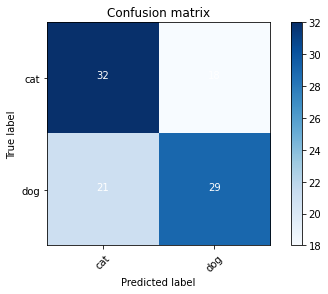

In [67]:
cm_plot_labels = test_batches.class_indices.keys()
plot_confusion_matrix(cm, classes=cm_plot_labels, title="Confusion matrix")

Viene confermata la presenza di overfitting. In questo momento non ci interessa, passiamo ad un modello importato chiamato VGG16 fatto apposta per lo scopo.

## Build fine-tuned VGG16 model

In [82]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [83]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [91]:
new_model = Sequential()
for layer in vgg16_model.layers[:-1]:
    new_model.add(layer)

In [93]:
new_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)     

In [94]:
for layer in new_model.layers:
    layer.trainable = False

In [95]:
new_model.add(Dense(units=2, activation='softmax'))


In [96]:
new_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)     